In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
%matplotlib inline

In [26]:


class NeuralNetwork(object):
    def __init__(self, layers):
        self.layers = layers
        self.numLayers = len(layers) - 1
        self.params = {}
        self.grad = {}

        for i in range(self.numLayers):
            self.params['W' + str(i+1)] = tf.Variable(np.random.normal(size=(self.layers[i], self.layers[i+1])))
            self.params['b' + str(i+1)] = tf.Variable(np.random.normal(size=(self.layers[i+1])))

    def feedforward(self, X):
        A = tf.convert_to_tensor(X, dtype=tf.float32)

        for i in range(self.numLayers):
            # hàm tf.cast() được sử dụng để chuyển đổi kiểu dữ liệu của tensor từ một kiểu sang kiểu khác. 
            W = tf.cast(self.params['W' + str(i+1)], dtype=tf.float32)
            b = tf.cast(self.params['b' + str(i+1)], dtype=tf.float32)

            # tf.matmul(A, W) thực hiện phép nhân ma trận giữa hai tensor A và W.
            Z = tf.matmul(A, W) + b

            if i != self.numLayers - 1:
                A = tf.nn.relu(Z)
            else:
                A = Z
        return A

    # Hàm computeLoss trong code của bạn sử dụng tf.nn.softmax_cross_entropy_with_logits để tính toán hàm mất mát (loss function) giữa đầu ra dự đoán (A) và nhãn thực tế (y) 
    # trong mô hình neural network.

# Đây là cách các đối số được sử dụng trong hàm tf.nn.softmax_cross_entropy_with_logits:

# labels=y: Đây là nhãn thực tế mà bạn cung cấp cho mô hình. Nó cần được chuẩn hóa về dạng xác suất one-hot encoding nếu chưa được làm. Trong mô hình phân loại,
#  y thường được biểu diễn dưới dạng one-hot encoding (ví dụ: [0, 1, 0] thay vì chỉ là lớp số 1). Hàm tf.nn.softmax_cross_entropy_with_logits tự động áp dụng hàm 
# softmax cho các giá trị đầu vào trước khi tính toán entropy cross.

# logits=A: Đây là đầu ra của mô hình, thường là các giá trị trước khi áp dụng hàm softmax (vì đã sử dụng hàm softmax trong hàm self.feedforward). A là kết quả đầu 
# ra của lớp cuối cùng của mạng neural.

# Hàm tf.nn.softmax_cross_entropy_with_logits tính toán entropy chéo (cross-entropy) giữa phân phối xác suất dự đoán của mô hình (sau softmax) và phân phối xác suất
#  thực tế của dữ liệu (labels). Sau đó, tf.reduce_mean được sử dụng để tính trung bình của toàn bộ các giá trị entropy chéo trên batch (nếu bạn đang sử dụng batch
#  để đào tạo mô hình).

# Hàm mất mát này được sử dụng để đánh giá sự khác biệt giữa dự đoán của mô hình và nhãn thực tế và là mục tiêu để mạng neural cố gắng học trong quá trình đào tạo.
    def computeLoss2(self, A, y):
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=A)
        return loss
    
    def computeLoss(self, A, y):
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=A)
        return tf.reduce_mean(loss)

    def updateParams(self, lr):
        for i in range(self.numLayers):
            self.params['W' + str(i+1)].assign_sub(lr * self.grad['W' + str(i+1)])
            self.params['b' + str(i+1)].assign_sub(lr * self.grad['b' + str(i+1)])

    def predict(self, X):
        A = self.feedforward(X)
        # Hàm tf.argmax() trong TensorFlow được sử dụng để tìm vị trí của giá trị lớn nhất trong tensor theo một trục cụ thể.
        # axis = 1 la theo hang 
        return tf.argmax(tf.nn.softmax(A), axis=1)

    def trainOnBatch(self, X, y, lr):
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.float32)

        with tf.GradientTape(persistent=True) as tape:
            A = self.feedforward(X)
            loss = self.computeLoss(A, y)

        for i in range(self.numLayers):
            self.grad['W' + str(i+1)] = tape.gradient(loss, self.params['W' + str(i+1)])
            self.grad['b' + str(i+1)] = tape.gradient(loss, self.params['b' + str(i+1)])
        del tape
        self.updateParams(lr)

    def train(self, X_train, y_train, X_test, y_test, epochs, steps_per_epoch, batch_size, lr):
        history = {
            'train_acc': [],
            'train_loss': [],
            'val_acc': []
        }

        for e in range(epochs):
            epochsTrainLoss = 0
            print('Epoch {}'.format(e), end='-')
            for i in range(steps_per_epoch):
                X_batch = X_train[i * batch_size:(i + 1) * batch_size]
                y_batch = y_train[i * batch_size:(i + 1) * batch_size]

                self.trainOnBatch(X_batch, y_batch, lr)
                batch_loss = self.computeLoss(self.feedforward(X_batch), y_batch)
                epochsTrainLoss += batch_loss

                if i % int(steps_per_epoch / 10) == 0:
                    print('-', end='')

            history['train_loss'].append(epochsTrainLoss / steps_per_epoch)
            train_preds = self.predict(X_train)
            # np.mean(np.argmax(y_train, axis=1) == train_preds.numpy()): Đoạn code này so sánh giữa kết quả dự đoán của mô hình (train_preds) và nhãn thực tế (y_train).
            #  Nó so sánh xem vị trí của lớp có xác suất cao nhất từ dự đoán của mô hình có trùng khớp với vị trí của nhãn thực tế hay không. Khi hai mảng này bằng nhau 
            # (tức là dự đoán chính xác), nó trả về True, ngược lại trả về False. Sau đó, hàm np.mean() tính trung bình các giá trị True và False này, trong đó giá trị 
            # True được tính là 1, False được tính là 0. Kết quả là tỷ lệ các dự đoán chính xác trên tập huấn luyện (accuracy).
            train_acc = np.mean(np.argmax(y_train, axis=1) == train_preds.numpy())
            history['train_acc'].append(train_acc)
            val_preds = self.predict(X_test)
            val_acc = np.mean(np.argmax(y_test, axis=1) == val_preds.numpy())
            history['val_acc'].append(val_acc)

            print('Train_acc:{}  . Val_acc:{}'.format(train_acc, val_acc))
        return history


In [3]:
def load():
    (X_train,y_train),(X_test,y_test) = tf.keras.datasets.mnist.load_data()
    # np.reshape(X_train, (X_train.shape[0], 784)): Sử dụng np.reshape để thay đổi hình dạng của X_train. Cụ thể, nó biến đổi mỗi hình ảnh 28x28 pixel (mỗi hàng là 28 pixel và có 28 hàng) 
    # thành một vector có độ dài 784 (28x28). Kích thước của X_train trở thành (số lượng mẫu, 784), trong đó mỗi hàng đại diện cho một hình ảnh.
    X_train = np.reshape(X_train,(X_train.shape[0],784))/255.0
    X_test = np.reshape(X_test,(X_test.shape[0],784))/255.0
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    return (X_train,y_train),(X_test,y_test)

def plot_random_images(x,y,p=None):
    indices = np.random.choice(range(x.shape[0]),10)
    y = np.argmax(y,axis=1)

    if p is None :
        p = y
    plt.figure(figsize=(10,5))
    for i , index in enumerate(indices):
        plt.subplot(2,5,i+1)
        plt.imshow(x[index].reshape((28,28)),cmap='binary')
        plt.xticks([])
        plt.yticks([])
        if y[index] == p[index]:
            col = 'g'
        else:
            col = 'r'
        plt.xlabel(str(p[index]),color = col)


In [31]:
(X_train,y_train),(X_test,y_test) = load()

In [14]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_train.shape

TensorShape([60000, 784])

In [22]:
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [6]:
X_train.shape

(60000, 784)

In [11]:
X_train[1,300:400]

array([0.99215686, 0.95294118, 0.19607843, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.14901961, 0.64705882, 0.99215686, 0.91372549,
       0.81568627, 0.32941176, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.99215686, 0.98823529,
       0.64705882, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02745098, 0.69803922,
       0.98823529, 0.94117647, 0.27843137, 0.0745098 , 0.10980392,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.99215686, 0.98823529, 0.76470588, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.22352941, 0.98823529, 0.98823529, 0.24705

In [9]:
y_train.shape

(60000, 10)

In [12]:
y_train[1,:]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

AttributeError: 'NoneType' object has no attribute 'show'

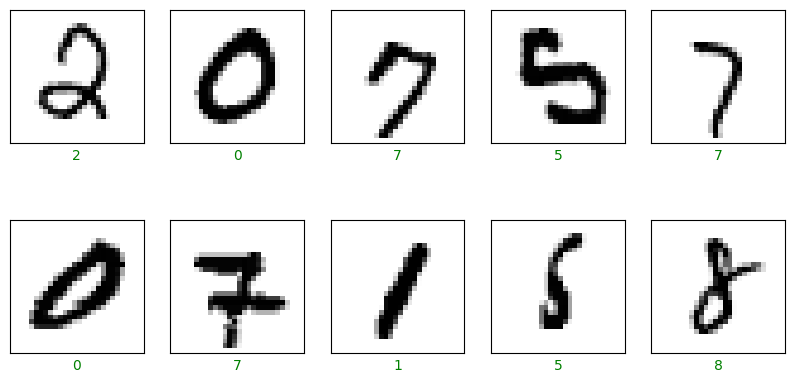

In [5]:
plot_random_images(X_train,y_train).show()

In [27]:
net = NeuralNetwork([784,128,128,10])


In [28]:
net.computeLoss2(net.feedforward(X_train), y_train)

<tf.Tensor: shape=(60000,), dtype=float32, numpy=
array([   0.    ,  919.3557, 2513.1963, ...,    0.    ,  454.1125,
       2181.8123], dtype=float32)>

In [29]:
net.computeLoss(net.feedforward(X_train), y_train)

<tf.Tensor: shape=(), dtype=float32, numpy=1148.3064>

In [34]:
batch_size = 120
epochs  = 7
steps_per_epochs = int(X_train.shape[0]/batch_size)
lr = 3e-3


In [35]:
history = net.train(X_train,y_train,X_test,y_test,epochs,steps_per_epochs,batch_size,lr)

Epoch 0-----------Train_acc:0.8037666666666666  . Val_acc:0.8043
Epoch 1-----------Train_acc:0.83795  . Val_acc:0.8363
Epoch 2-----------Train_acc:0.8544333333333334  . Val_acc:0.8507
Epoch 3-----------Train_acc:0.8640833333333333  . Val_acc:0.8614
Epoch 4-----------Train_acc:0.8702833333333333  . Val_acc:0.8672
Epoch 5-----------Train_acc:0.8752  . Val_acc:0.8699
Epoch 6-----------Train_acc:0.88035  . Val_acc:0.8755


IndexError: index 43744 is out of bounds for axis 0 with size 10000

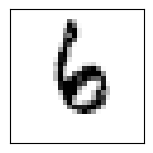

In [36]:
y_preds = net.predict(X_test).numpy()
plot_random_images(X_train,y_train,y_preds).show()